In [1]:
import cv2                 # working with, mainly resizing, images
import numpy as np         # dealing with arrays
import os                  # dealing with directories
from random import shuffle # mixing up or currently ordered data that might lead our network astray in training.
from tqdm import tqdm      # a nice pretty percentage bar for tasks. Thanks to viewer Daniel BA1/4hler for this suggestion

In [2]:
TRAIN_DIR = '/home/sauradip/Desktop/cnn-tf/data/resized'
TEST_DIR = '/home/sauradip/Desktop/cnn-tf/data/resized'

In [3]:
IMG_SIZE = 30
LR = 1e-3

In [4]:
MODEL_NAME = 'gesture-{}-{}.model'.format(LR, '5conv-basic') # just so we remember which saved model is which, sizes must match

In [5]:
def label_img(img):
    word_label = img[0]
    # conversion to one-hot array [index,v-shape,fist,terminal]
   
    if word_label == 'i': return [1,0,0,0]                            
    elif word_label == 'v': return [0,1,0,0]
    elif word_label == 'f': return [0,0,1,0]
    elif word_label == 't': return [0,0,0,1]

In [6]:
def create_train_data():
    training_data = []
    for img in tqdm(os.listdir(TRAIN_DIR)):
        label = label_img(img)
        path = os.path.join(TRAIN_DIR,img)
        img = cv2.imread(path , cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, (IMG_SIZE,IMG_SIZE))
        training_data.append([np.array(img),np.array(label)])
    shuffle(training_data)
    np.save('train_data.npy', training_data)
    return training_data

In [9]:
def process_test_data():
    testing_data = []
    for img in tqdm(os.listdir(TEST_DIR)):
        path = os.path.join(TEST_DIR,img)
        img_num = img[0]
        img = cv2.imread(path,cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, (IMG_SIZE,IMG_SIZE))
        testing_data.append([np.array(img), img_num])
        
    shuffle(testing_data)
    np.save('test_data.npy', testing_data)
    return testing_data


In [10]:
train_data = create_train_data()
# If you have already created the dataset:
#train_data = np.load('train_data.npy')

100%|██████████| 2879/2879 [00:00<00:00, 9602.95it/s]


In [11]:
import tflearn
from tflearn.layers.conv import conv_2d, max_pool_2d
from tflearn.layers.core import input_data, dropout, fully_connected
from tflearn.layers.estimator import regression


Instructions for updating:
Use the retry module or similar alternatives.
hdf5 is not supported on this machine (please install/reinstall h5py for optimal experience)
Scipy not supported!


In [13]:
import tensorflow as tf
tf.reset_default_graph()
convnet = input_data(shape=[None, IMG_SIZE, IMG_SIZE, 1], name='input')


convnet = conv_2d(convnet, 32, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)
convnet = dropout(convnet, 0.8)
convnet = conv_2d(convnet, 64, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)
convnet = dropout(convnet, 0.8)
convnet = conv_2d(convnet, 128, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)
convnet = dropout(convnet, 0.8)
convnet = conv_2d(convnet, 256, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)
convnet = dropout(convnet, 0.8)
convnet = conv_2d(convnet, 512, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)
convnet = dropout(convnet, 0.8)
convnet = fully_connected(convnet, 1024, activation='relu')
convnet = dropout(convnet, 0.8)

convnet = fully_connected(convnet, 4, activation='softmax')
convnet = regression(convnet, optimizer='adam', learning_rate=LR, loss='categorical_crossentropy', name='targets')

model = tflearn.DNN(convnet, tensorboard_dir='log')



Instructions for updating:
Use tf.initializers.variance_scaling instead with distribution=uniform to get equivalent behavior.
Instructions for updating:
keep_dims is deprecated, use keepdims instead


In [15]:
train=[]
test=[]
train = train_data[:-1500]
test = train_data[-1500:]

X = np.array([i[0] for i in train]).reshape(-1,IMG_SIZE,IMG_SIZE,1)
Y = [i1[1] for i1 in train]

test_x = np.array([i2[0] for i2 in test]).reshape(-1,IMG_SIZE,IMG_SIZE,1)
test_y = [i3[1] for i3 in test]

model.fit({'input': X}, {'targets': Y}, n_epoch=5, validation_set=({'input': test_x}, {'targets': test_y}), 
    snapshot_step=50, show_metric=True, run_id=MODEL_NAME)

#model.save(MODEL_NAME)

Training Step: 109  | total loss: 0.03348 | time: 32.846s
| Adam | epoch: 005 | loss: 0.03348 - acc: 0.9908 -- iter: 1344/1379
Training Step: 110  | total loss: 0.03168 | time: 35.202s
| Adam | epoch: 005 | loss: 0.03168 - acc: 0.9901 | val_loss: 0.04802 - val_acc: 0.9920 -- iter: 1379/1379
--


100%|██████████| 2879/2879 [00:00<00:00, 8065.65it/s]


NameError: name 'str_label' is not defined

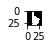

In [16]:
import matplotlib.pyplot as plt

# if you need to create the data:
test_data = process_test_data()
# if you already have some saved:
#test_data = np.load('test_data.npy')

fig=plt.figure()

for num,data in enumerate(test_data[:100]):
    #[index,v-shape,fist,terminal]
    
    img_num = data[1]
    img_data = data[0]
    
    y = fig.add_subplot(5,20,num+1)
    orig = img_data
    data = img_data.reshape(IMG_SIZE,IMG_SIZE,1)
    #model_out = model.predict([data])[0]
    model_out = model.predict([data])[0]
    
    if np.array_equal((model_out),([1.,0.,0.,0.])):
            str_label='Index'
    elif np.array_equal((model_out),np.array([0.,1.,0.,0.]) ): 
        str_label='V-Shape'
    elif np.array_equal((model_out) , np.array([0.,0.,1.,0.])): 
        str_label='Fist'
    elif np.array_equal((model_out) , np.array([0.,0.,0.,1.])): 
        str_label='Terminal'
        
    y.imshow(orig,cmap='gray')
    plt.title(str_label)
    y.axes.get_xaxis().set_visible(False)
    y.axes.get_yaxis().set_visible(False)
plt.show()

In [13]:
model_out

array([1., 0., 0., 0.], dtype=float32)

In [14]:
np.argmax(model_out)

0

In [15]:
train_data[:-1000]

[[array([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
            0,   0,   0,   1,   0,   0,   2,   0,   0,   1,   0,   0,   0,
            0,   0,   0,   0],
         [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
            0,   0,   0,   0,   2,   1,   0,   0,   2,   0,   2,   0,   0,
            0,   0,   0,   0],
         [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
            0,   0,   0,   1,   0,   0,   0,   1,   0,   1,   0,   0,   0,
            0,   0,   0,   0],
         [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
            0,   0,   0,   2,   0,   2,   2,   0,   0,   1,   2,   0,   0,
            0,   0,   0,   0],
         [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
            0,   0,   0,   0,   1,   0,   0,   3,   0,   0,   0,   0,   0,
            0,   0,   0,   0],
         [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
            0,   0, 